In [1]:
import networkx as nx
from networkx.readwrite import json_graph
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

def graphFrame(fileloc):
    col_names = ["id", "degree", "density", "No_nodes", "No_edges", "centrality"]
    gframe = pd.DataFrame(columns= col_names)
    for file in [file for file in os.listdir(fileloc) if file.endswith('.json')]:
        with open(fileloc + file) as json_file:
            data = json.load(json_file)
        new_graph = json_graph.tree_graph(data)
        id = list(new_graph.nodes("tweet_id"))[0][1]
        degree = list(nx.degree(new_graph))[0][1]
        density = nx.density(new_graph)
        nodes = nx.number_of_nodes(new_graph)
        edges = nx.number_of_edges(new_graph)
        centrality = dict(nx.degree_centrality(new_graph))[list(new_graph.nodes("id"))[0][0]]
        entry = [id,degree, density, nodes, edges, centrality]
        entryDf = pd.Series(entry, index = gframe.columns)
        gframe = gframe.append(entryDf, ignore_index=True)
    return gframe

In [2]:
with open('graph/gossipcop_fake/gossipcop-1000240645.json') as f:
    json_data = json.loads(f.read())

with open('graph/gossipcop_real/gossipcop-541230.json') as f:
    json_data2 = json.loads(f.read())

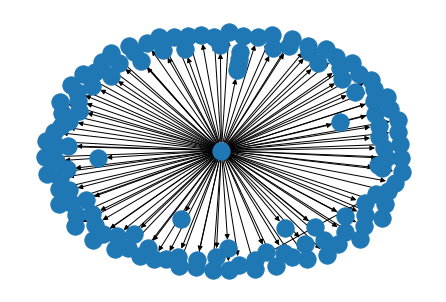

In [3]:
new_graph = json_graph.tree_graph(json_data)
nx.draw(new_graph)

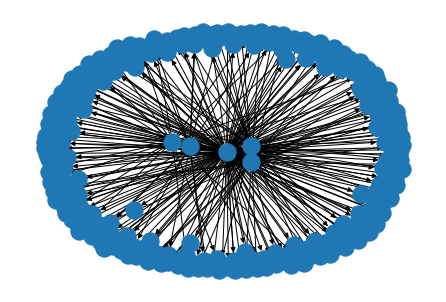

In [4]:
new_graph2 = json_graph.tree_graph(json_data2)
nx.draw(new_graph2)

In [5]:
gossiFake = graphFrame('graph/gossipcop_fake/')
gossiReal = graphFrame('graph/gossipcop_real/')
politiFake = graphFrame('graph/politifact_fake/')
politiReal = graphFrame('graph/politifact_real/')

In [6]:
chosenCols = ['id','title', 'label']

gfake = pd.read_csv('text/gossipcop_fake.csv')
gfake['label'] = 'fake'
gfake = gfake[chosenCols]

greal = pd.read_csv('text/gossipcop_real.csv')
greal['label'] = 'real'
greal = greal[chosenCols]

pfake = pd.read_csv('text/politifact_fake.csv')
pfake['label'] = 'fake'
pfake = pfake[chosenCols]

preal = pd.read_csv('text/politifact_real.csv')
preal['label'] = 'real'
preal = preal[chosenCols]

In [7]:
NewsText = gfake.append([greal,pfake,preal])
NewsPath = gossiFake.append([gossiReal,politiFake,politiReal])

In [8]:
NewsPath[['degree','No_nodes', 'No_edges']] = NewsPath[['degree','No_nodes', 'No_edges']].apply(pd.to_numeric)

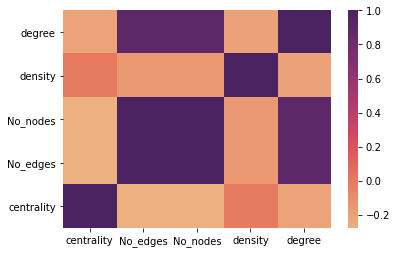

In [9]:
pathcorr = NewsPath.corr()
sns.heatmap(pathcorr, cmap="flare").invert_xaxis()

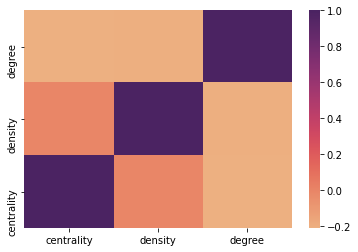

In [10]:
pathcorr2 = NewsPath[["degree", "density", "centrality"]].corr()
sns.heatmap(pathcorr2, cmap="flare").invert_xaxis()

In [115]:
hybridSet = pd.merge(left=NewsText, right=NewsPath, left_on='id', right_on='id')

In [116]:
hybridSet = hybridSet[['title', "degree", "density", "centrality", 'label']]

<AxesSubplot:>

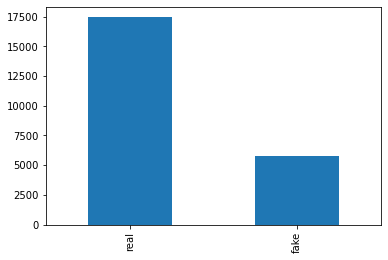

In [13]:
NewsText["label"].value_counts().plot.bar()

<AxesSubplot:>

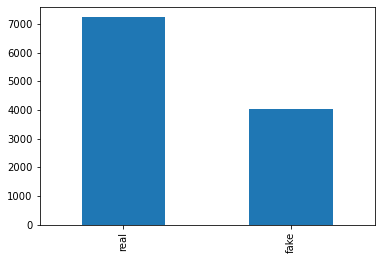

In [14]:
hybridSet["label"].value_counts().plot.bar()

In [15]:
hybridSet[["density", "degree", "centrality"]].describe()

,density,degree,centrality
count,11259.000000,11259.000000,11259.000000
mean,0.030916,125.387779,0.757562
std,0.045908,337.072094,0.224301
min,0.000025,1.000000,0.013986
25%,0.008231,23.000000,0.613749
50%,0.014925,54.000000,0.832258
75%,0.032258,88.000000,0.951220
max,0.333333,17520.000000,0.995833


<AxesSubplot:title={'center':'centrality'}, xlabel='[label]'>

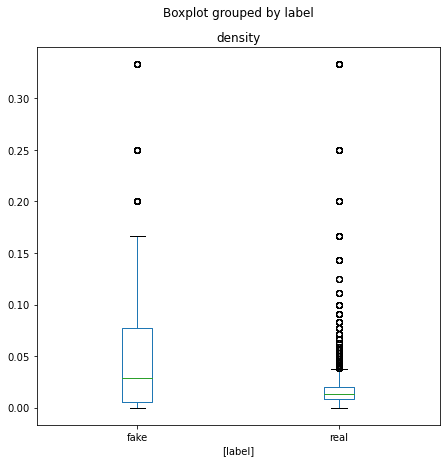

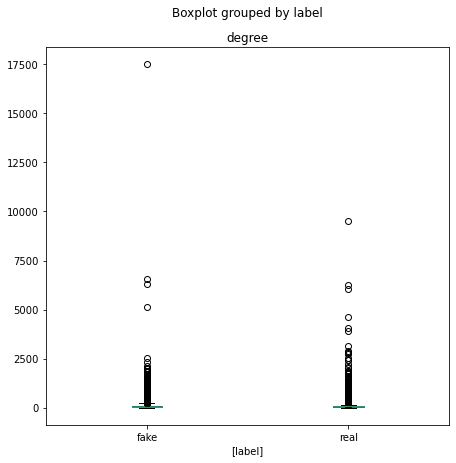

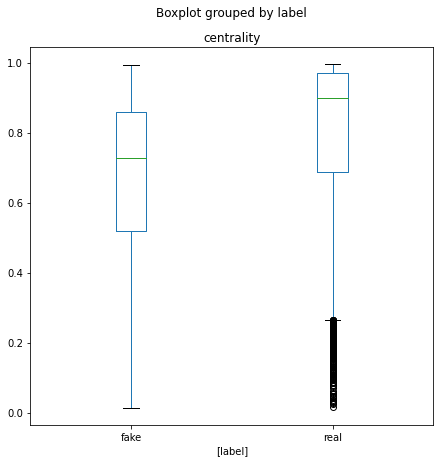

In [118]:
hybridSet[["density", "label"]].boxplot(by="label", figsize=(7,7), grid=False)
hybridSet[["degree", "label"]].boxplot(by="label", figsize=(7,7), grid=False)
hybridSet[["centrality", "label"]].boxplot(by="label", figsize=(7,7), grid=False)

# Data Transformation and Partitioning

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

In [18]:
hybridSet = hybridSet.sample(frac=1).reset_index(drop=True)
hybridSet['label'] = hybridSet['label'].replace(['fake', 'real'], [0,1])

In [19]:
y = hybridSet.pop('label')
x = hybridSet

In [20]:
x.shape

(11259, 4)

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=1, \
                                                stratify=y)

In [22]:
x_train.shape

(9007, 4)

In [23]:
x_test.shape

(2252, 4)

In [24]:
textVectorizer = TfidfVectorizer(analyzer='word', sublinear_tf=True).fit(x_train['title'])

x_trainText = textVectorizer.transform(x_train['title']).toarray()
x_testText = textVectorizer.transform(x_test['title']).toarray()

In [25]:
x_trainText.shape

(9007, 11501)

In [26]:
textVectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': True,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [31]:
decomposer = TruncatedSVD(n_components=100, random_state=1).fit(x_trainText)

x_trainSVD = decomposer.transform(x_trainText)
x_testSVD = decomposer.transform(x_testText)

In [28]:
addFeatures = ['degree', 'density', 'centrality']

scalar = MinMaxScaler().fit(x_train[addFeatures].values)

x_trainGraph = scalar.transform(x_train[addFeatures].values)
x_testGraph = scalar.transform(x_test[addFeatures].values)

In [33]:
x_trainVect = np.concatenate((x_trainSVD, x_trainGraph), axis=1)
x_testVect = np.concatenate((x_testSVD, x_testGraph), axis=1)

In [43]:
x_trainNB = np.concatenate((x_trainText, x_trainGraph), axis=1)
x_testNB = np.concatenate((x_testText, x_testGraph), axis=1)

In [34]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Model Training and Tuning

In [35]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,\
     precision_score, recall_score, confusion_matrix
from skopt import BayesSearchCV

cv = KFold(n_splits=5, random_state=1, shuffle=True)

In [63]:
def evalfunc(model,xtest,ytest):
    print(f'Tunned Training Acc: {model.best_score_}')
    print(f'Best Parameters: {model.best_params_}')
    y_test_pred = model.predict(xtest)
    print(f'Accuracy: {accuracy_score(ytest, y_test_pred)}')
    print(f'F1: {f1_score(ytest, y_test_pred)}')
    print(f'Precision: {precision_score(ytest, y_test_pred)}')
    print(f'Recall: {recall_score(ytest, y_test_pred)}')
    sns.heatmap(confusion_matrix(ytest, y_test_pred), annot=True, fmt='g', cmap="flare")\
        .invert_xaxis()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

## Logistic Regression

In [44]:
logParams = {
    'solver': ['liblinear', 'saga'],  
    'penalty': ['l1','l2'],
    'tol': (1e-4, 1e-3, 'log-uniform'),
    'C': (1, 100, 'log-uniform')
}

logClfsearch = BayesSearchCV(estimator=LogisticRegression(random_state=0),\
                             search_spaces=logParams,cv=cv)

logClfsearch.fit(x_trainVect, y_train)

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=LogisticRegression(random_state=0),
              search_spaces={'C': (1, 100, 'log-uniform'),
                             'penalty': ['l1', 'l2'],
                             'solver': ['liblinear', 'saga'],
                             'tol': (0.0001, 0.001, 'log-uniform')})

In [45]:
TextlogClfsearch = BayesSearchCV(estimator=LogisticRegression(random_state=0),\
                             search_spaces=logParams,cv=cv)

TextlogClfsearch.fit(x_trainSVD, y_train)

/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=LogisticRegression(random_state=0),
              search_spaces={'C': (1, 100, 'log-uniform'),
                             'penalty': ['l1', 'l2'],
                             'solver': ['liblinear', 'saga'],
                             'tol': (0.0001, 0.001, 'log-uniform')})

Tunned Training Acc: 0.8178083712667925
Best Parameters: OrderedDict([('C', 68), ('penalty', 'l1'), ('solver', 'liblinear'), ('tol', 0.001)])
Accuracy: 0.7992895204262878
F1: 0.8515111695137977
Precision: 0.8105065666041276
Recall: 0.8968858131487889


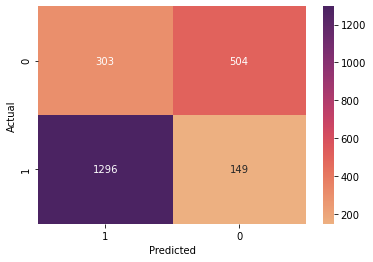

In [65]:
evalfunc(logClfsearch,x_testVect,y_test)

Tunned Training Acc: 0.7638503386255134
Best Parameters: OrderedDict([('C', 11), ('penalty', 'l2'), ('solver', 'liblinear'), ('tol', 0.001)])
Accuracy: 0.7446714031971581
F1: 0.8155277510426692
Precision: 0.7601674641148325
Recall: 0.8795847750865052


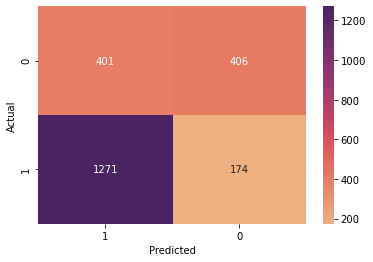

In [67]:
evalfunc(TextlogClfsearch,x_testSVD,y_test)

## Naive Bayes

In [48]:
NBParams = {
    'alpha': (0, 1, 'log-uniform'),
    'fit_prior': [True, False]
}

NBClfsearch = BayesSearchCV(estimator=MultinomialNB(),\
                             search_spaces=NBParams,cv=cv)

NBClfsearch.fit(x_trainNB, y_train)

/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/space/space.py:502: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.low) / self.log_base,
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/space/space.py:504: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.low) / self.log_base)
/home/olumide/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/home/olumide/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/home/olumide/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will re

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=MultinomialNB(),
              search_spaces={'alpha': (0, 1, 'log-uniform'),
                             'fit_prior': [True, False]})

In [76]:
TextNBClfsearch = BayesSearchCV(estimator=MultinomialNB(),\
                             search_spaces=NBParams,cv=cv)

TextNBClfsearch.fit(x_trainText, y_train)

/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/space/space.py:502: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.low) / self.log_base,
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/space/space.py:504: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.low) / self.log_base)
/home/olumide/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/home/olumide/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/home/olumide/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will re

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=MultinomialNB(),
              search_spaces={'alpha': (0, 1, 'log-uniform'),
                             'fit_prior': [True, False]})

Tunned Training Acc: 0.8035972021760852
Best Parameters: OrderedDict([('alpha', 1), ('fit_prior', False)])
Accuracy: 0.7850799289520426
F1: 0.8372562205783456
Precision: 0.8142576847612819
Recall: 0.8615916955017301


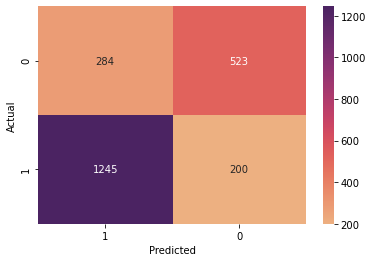

In [68]:
evalfunc(NBClfsearch,x_testNB,y_test)

Tunned Training Acc: 0.7829465970911513
Best Parameters: OrderedDict([('alpha', 1), ('fit_prior', True)])
Accuracy: 0.7615452930728241
F1: 0.8340030911901082
Precision: 0.7536312849162011
Recall: 0.9335640138408304


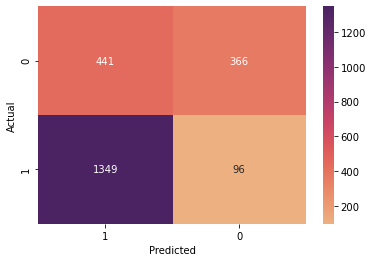

In [77]:
evalfunc(TextNBClfsearch,x_testText,y_test)

## K Nearest Neighbours 

In [52]:
KNNParams = {
    'n_neighbors': (1, 21),  
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

KNClfsearch = BayesSearchCV(estimator=KNeighborsClassifier(),\
                             search_spaces=KNNParams,cv=cv)

KNClfsearch.fit(x_trainVect, y_train)

/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=KNeighborsClassifier(),
              search_spaces={'metric': ['euclidean', 'manhattan', 'minkowski'],
                             'n_neighbors': (1, 21),
                             'weights': ['uniform', 'distance']})

In [53]:
TextKNClfsearch = BayesSearchCV(estimator=KNeighborsClassifier(),\
                             search_spaces=KNNParams,cv=cv)

TextKNClfsearch.fit(x_trainSVD, y_train)

/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=KNeighborsClassifier(),
              search_spaces={'metric': ['euclidean', 'manhattan', 'minkowski'],
                             'n_neighbors': (1, 21),
                             'weights': ['uniform', 'distance']})

Tunned Training Acc: 0.8037082269346064
Best Parameters: OrderedDict([('metric', 'minkowski'), ('n_neighbors', 8), ('weights', 'distance')])
Accuracy: 0.7881882770870338
F1: 0.845780795344326
Precision: 0.7936893203883495
Recall: 0.9051903114186851


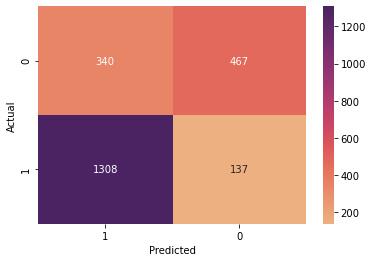

In [72]:
evalfunc(KNClfsearch,x_testVect,y_test)

Tunned Training Acc: 0.754635283668258
Best Parameters: OrderedDict([('metric', 'minkowski'), ('n_neighbors', 21), ('weights', 'distance')])
Accuracy: 0.7375666074600356
F1: 0.8162884675163197
Precision: 0.7409706546275395
Recall: 0.9086505190311419


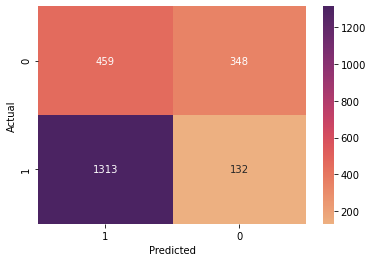

In [73]:
evalfunc(TextKNClfsearch,x_testSVD,y_test)

## Support Vector Classifier

In [56]:
SVMParams = {
    'gamma': (1e-6, 100.0, 'log-uniform'),  
    'degree': (1,5),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': (1e-6, 100.0, 'log-uniform')
}

SVMClfsearch = BayesSearchCV(estimator=SVC(),\
                             search_spaces=SVMParams,cv=cv)

SVMClfsearch.fit(x_trainVect, y_train)

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=SVC(),
              search_spaces={'C': (1e-06, 100.0, 'log-uniform'),
                             'degree': (1, 5),
                             'gamma': (1e-06, 100.0, 'log-uniform'),
                             'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [57]:
TextSVMClfsearch = BayesSearchCV(estimator=SVC(),\
                             search_spaces=SVMParams,cv=cv)

TextSVMClfsearch.fit(x_trainSVD, y_train)

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=SVC(),
              search_spaces={'C': (1e-06, 100.0, 'log-uniform'),
                             'degree': (1, 5),
                             'gamma': (1e-06, 100.0, 'log-uniform'),
                             'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

Tunned Training Acc: 0.8379038525591207
Best Parameters: OrderedDict([('C', 100.0), ('degree', 1), ('gamma', 0.060639954514511846), ('kernel', 'rbf')])
Accuracy: 0.8192717584369449
F1: 0.8656322218553979
Precision: 0.8276515151515151
Recall: 0.9072664359861592


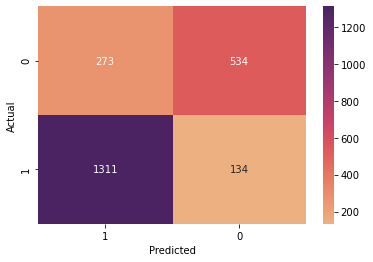

In [74]:
evalfunc(SVMClfsearch,x_testVect,y_test)

Tunned Training Acc: 0.7641834129010769
Best Parameters: OrderedDict([('C', 100.0), ('degree', 1), ('gamma', 100.0), ('kernel', 'linear')])
Accuracy: 0.7411190053285968
F1: 0.8162622124172706
Precision: 0.7494212962962963
Recall: 0.8961937716262975


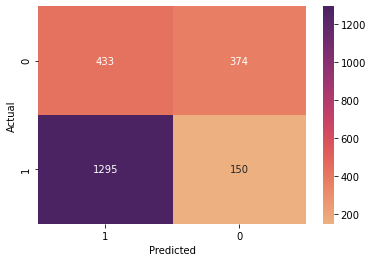

In [75]:
evalfunc(TextSVMClfsearch,x_testSVD,y_test)

## Random Forest Classifier 

In [78]:
RFParams = {
    'bootstrap': [True, False],
    'n_estimators': [10,50,100,500,1000],  
    'max_features': ['sqrt', 'log2', 'auto']
}

RFClfsearch = BayesSearchCV(estimator=RandomForestClassifier(),\
                             search_spaces=RFParams,cv=cv)

RFClfsearch.fit(x_trainVect, y_train)

/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=RandomForestClassifier(),
              search_spaces={'bootstrap': [True, False],
                             'max_features': ['sqrt', 'log2', 'auto'],
                             'n_estimators': [10, 50, 100, 500, 1000]})

### Text Classifier

In [79]:
TextRFClfsearch = BayesSearchCV(estimator=RandomForestClassifier(),\
                             search_spaces=RFParams,cv=cv)

TextRFClfsearch.fit(x_trainSVD, y_train)

/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/olumide/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=RandomForestClassifier(),
              search_spaces={'bootstrap': [True, False],
                             'max_features': ['sqrt', 'log2', 'auto'],
                             'n_estimators': [10, 50, 100, 500, 1000]})

Tunned Training Acc: 0.8474519817919396
Best Parameters: OrderedDict([('bootstrap', False), ('max_features', 'sqrt'), ('n_estimators', 1000)])
Accuracy: 0.8392539964476021
F1: 0.8781965006729475
Precision: 0.8546168958742633
Recall: 0.903114186851211


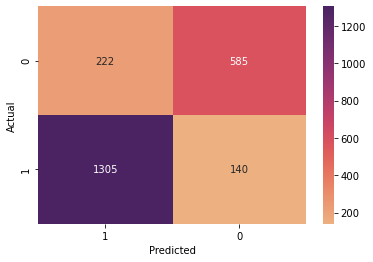

In [80]:
evalfunc(RFClfsearch,x_testVect,y_test)

Tunned Training Acc: 0.7725102697901632
Best Parameters: OrderedDict([('bootstrap', True), ('max_features', 'sqrt'), ('n_estimators', 1000)])
Accuracy: 0.7548845470692718
F1: 0.823076923076923
Precision: 0.7665671641791045
Recall: 0.8885813148788927


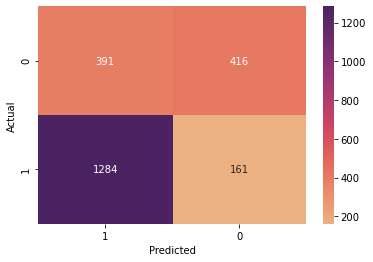

In [81]:
evalfunc(TextRFClfsearch,x_testSVD,y_test)

# Hypothesis Testing

In [121]:
from scipy import stats

In [128]:
def paired_t_test(modMix,modTex,xMix,xTex):
    a = modMix.predict(xMix)
    b = modTex.predict(xTex)
    print(stats.ttest_rel(a, b))

In [129]:
paired_t_test(logClfsearch,TextlogClfsearch,x_testVect,x_testSVD)

Ttest_relResult(statistic=-4.436449168913354, pvalue=9.58605967853607e-06)


In [133]:
paired_t_test(NBClfsearch,TextNBClfsearch,x_testNB,x_testText)

Ttest_relResult(statistic=-17.17799101141771, pvalue=3.0282679836995947e-62)


In [130]:
paired_t_test(KNClfsearch,TextKNClfsearch,x_testVect,x_testSVD)

Ttest_relResult(statistic=-6.711790057870152, pvalue=2.4250800095333936e-11)


In [131]:
paired_t_test(SVMClfsearch,TextSVMClfsearch,x_testVect,x_testSVD)

Ttest_relResult(statistic=-7.8216675843414025, pvalue=7.946488697704613e-15)


In [132]:
paired_t_test(RFClfsearch,TextRFClfsearch,x_testVect,x_testSVD)

Ttest_relResult(statistic=-7.548228388501442, pvalue=6.368305877972863e-14)
